#### 数据预处理

In [5]:
import pandas as pd

data_ori=pd.read_csv('olympics.csv')
data_ori.head()

,id,name,sex,age,height,weight,team,noc,games,year,season,city,sport,event,medal
0,1,A Dijiang,M,24.0,180.0,80.0,China,CHN,1992 Summer,1992,Summer,Barcelona,Basketball,Basketball Men's Basketball,NaN
1,2,A Lamusi,M,23.0,170.0,60.0,China,CHN,2012 Summer,2012,Summer,London,Judo,Judo Men's Extra-Lightweight,NaN
2,3,Gunnar Nielsen Aaby,M,24.0,NaN,NaN,Denmark,DEN,1920 Summer,1920,Summer,Antwerpen,Football,Football Men's Football,NaN
3,4,Edgar Lindenau Aabye,M,34.0,NaN,NaN,Denmark/Sweden,DEN,1900 Summer,1900,Summer,Paris,Tug-Of-War,Tug-Of-War Men's Tug-Of-War,Gold
4,5,Christine Jacoba Aaftink,F,21.0,185.0,82.0,Netherlands,NED,1988 Winter,1988,Winter,Calgary,Speed Skating,Speed Skating Women's 500 metres,NaN


In [14]:
data_new=data_ori[data_ori['year']>=1960]
data_new.head()

data_new=data_new[~data_new['year'].isin([1980,1984])]

data_new['noc']=data_new['noc'].replace({'GDR':'GER','FRG':'GER'}) #合并德国

data_medal=data_new[data_new['medal'].notna()] #保留有奖牌的行

data_medal.head()

,id,name,sex,age,height,weight,team,noc,games,year,season,city,sport,event,medal
40,16,Juhamatti Tapio Aaltonen,M,28.0,184.0,85.0,Finland,FIN,2014 Winter,2014,Winter,Sochi,Ice Hockey,Ice Hockey Men's Ice Hockey,Bronze
60,20,Kjetil Andr Aamodt,M,20.0,176.0,85.0,Norway,NOR,1992 Winter,1992,Winter,Albertville,Alpine Skiing,Alpine Skiing Men's Super G,Gold
61,20,Kjetil Andr Aamodt,M,20.0,176.0,85.0,Norway,NOR,1992 Winter,1992,Winter,Albertville,Alpine Skiing,Alpine Skiing Men's Giant Slalom,Bronze
63,20,Kjetil Andr Aamodt,M,22.0,176.0,85.0,Norway,NOR,1994 Winter,1994,Winter,Lillehammer,Alpine Skiing,Alpine Skiing Men's Downhill,Silver
64,20,Kjetil Andr Aamodt,M,22.0,176.0,85.0,Norway,NOR,1994 Winter,1994,Winter,Lillehammer,Alpine Skiing,Alpine Skiing Men's Super G,Bronze


In [18]:
data_sum=data_medal[data_medal['season']=='Summer']
data_win=data_medal[data_medal['season']=='Winter']

data_grouped_sum=data_sum.groupby(['year', 'noc', 'medal']).size().unstack(fill_value=0).reset_index() #分组
data_grouped_win=data_win.groupby(['year', 'noc', 'medal']).size().unstack(fill_value=0).reset_index() #分组

data_grouped_sum['total']=data_grouped_sum.get('Gold',0)+data_grouped_sum.get('Silver',0)+data_grouped_sum.get('Bronze',0)
data_grouped_win['total']=data_grouped_win.get('Gold',0)+data_grouped_win.get('Silver',0)+data_grouped_win.get('Bronze',0)
data_grouped_sum.head()

# data_grouped_sum.to_csv('data_summer',index=False)
# data_grouped_win.to_csv('data_winter',index=False)

medal,year,noc,Bronze,Gold,Silver,total
0,1960,ARG,1,0,3,4
1,1960,AUS,11,11,24,46
2,1960,AUT,0,1,2,3
3,1960,BEL,2,0,2,4
4,1960,BRA,13,0,0,13


#### 特征构建

In [21]:
pivot = data_grouped_sum.pivot(index='noc', columns='year', values='total').fillna(0)
print(pivot.head()) #变成【国家 × 年份】矩阵

# 训练特征列：1960–2012（共14届）
train_years = [y for y in range(1960, 2013, 4) if y not in [1980, 1984]]

# 验证年份（2016）
val_year = 2016

# 提取训练数据
X_train = pivot[train_years]
y_train = pivot[val_year]

# 去除 2016 没数据的国家
mask = y_train > 0
X_train = X_train[mask]
y_train = y_train[mask]



year  1960  1964  1968  1972  1976  1988  1992  1996  2000  2004  2008  2012  \
noc                                                                            
AFG    0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   1.0   1.0   
AHO    0.0   0.0   0.0   0.0   0.0   1.0   0.0   0.0   0.0   0.0   0.0   0.0   
ALG    0.0   0.0   0.0   0.0   0.0   0.0   2.0   3.0   5.0   0.0   2.0   1.0   
ARG    4.0   1.0   2.0   1.0   0.0  13.0   2.0  20.0  20.0  49.0  51.0  19.0   
ARM    0.0   0.0   0.0   0.0   0.0   0.0   0.0   2.0   1.0   0.0   6.0   3.0   

year  2016  
noc         
AFG    0.0  
AHO    0.0  
ALG    2.0  
ARG   22.0  
ARM    4.0  


#### 训练

In [26]:
! pip install lightgbm

In [22]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# 预测 2016 年奖牌总数
y_pred_2016 = model.predict(X_train)

# 验证指标
mse = mean_squared_error(y_train, y_pred_2016)
r2 = r2_score(y_train, y_pred_2016)

print(f"验证集 2016 年预测 MSE: {mse:.2f}, R²: {r2:.2f}")


验证集 2016 年预测 MSE: 70.70, R²: 0.96


In [24]:
# 构造2020预测的特征列。与训练特征一样
predict_years = train_years

# 有效国家
X_predict_2020 = pivot[predict_years]

# 预测
y_pred_2020 = model.predict(X_predict_2020)

# 构造预测结果
df_pred_2020 = pd.DataFrame({
    'noc': X_predict_2020.index,
    'predicted_total_2020': y_pred_2020
}).sort_values('predicted_total_2020', ascending=False)

print(df_pred_2020.head(10))


     noc  predicted_total_2020
130  USA                212.71
45   GER                143.54
43   GBR                111.69
20   CHN                108.63
102  RUS                102.41
5    AUS                 93.81
41   FRA                 85.44
64   JPN                 77.31
61   ITA                 68.27
18   CAN                 57.64


#### 结果分析

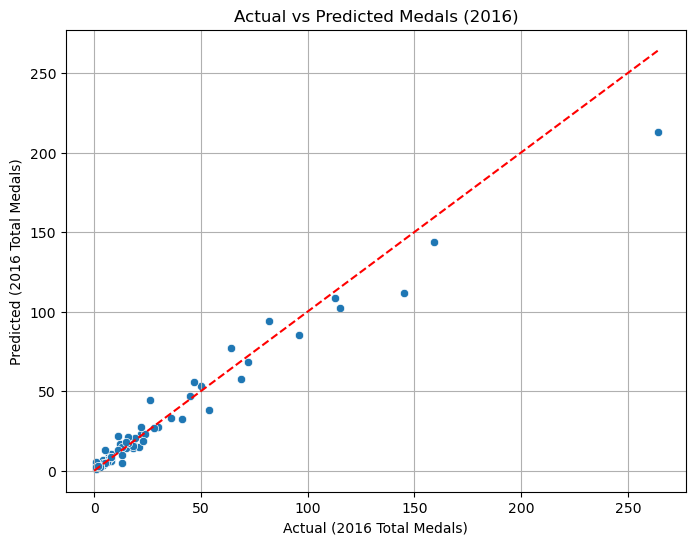

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

#预测值 vs 实际值 散点图（验证集）
plt.figure(figsize=(8,6))
sns.scatterplot(x=y_train, y=y_pred_2016)
plt.xlabel("Actual (2016 Total Medals)")
plt.ylabel("Predicted (2016 Total Medals)")
plt.title("Actual vs Predicted Medals (2016)")
plt.plot([0, max(y_train.max(), y_pred_2016.max())], [0, max(y_train.max(), y_pred_2016.max())], 'r--')
plt.grid(True)
plt.show()


C:\Users\under\AppData\Local\Temp\ipykernel_2316\376336359.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='predicted_total_2020', y='noc', data=top_10, palette='Blues_d')


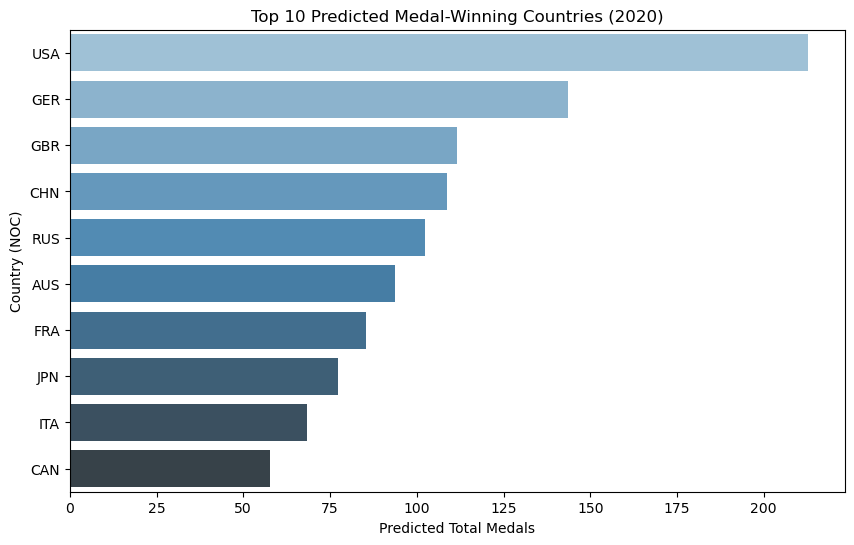

In [ ]:
#预测2020年结果前十国家条形图
top_10 = df_pred_2020.sort_values(by='predicted_total_2020', ascending=False).head(10)

plt.figure(figsize=(10,6))
sns.barplot(x='predicted_total_2020', y='noc', data=top_10, palette='Blues_d')
plt.title("Top 10 Predicted Medal-Winning Countries (2020)")
plt.xlabel("Predicted Total Medals")
plt.ylabel("Country (NOC)")
plt.show()


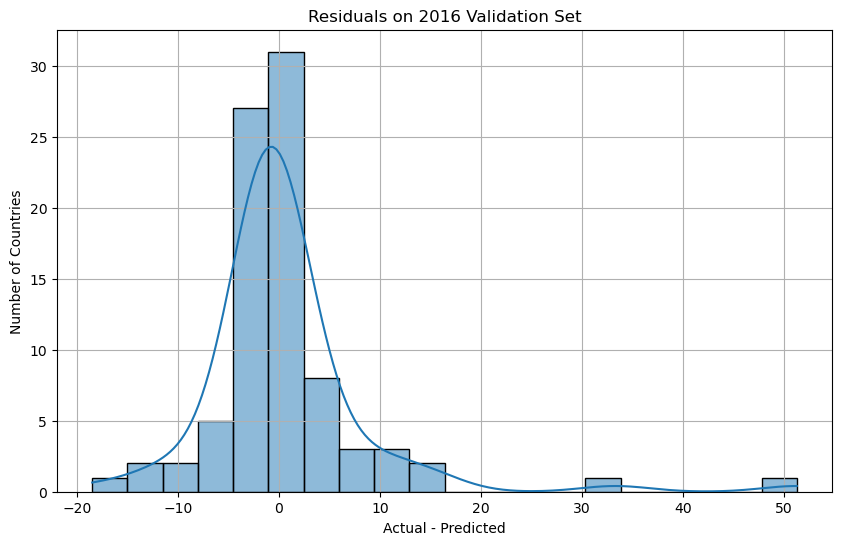

In [ ]:
#残差图（预测误差）
residuals = y_train - y_pred_2016
plt.figure(figsize=(10,6))
sns.histplot(residuals, bins=20, kde=True)
plt.title("Residuals on 2016 Validation Set")
plt.xlabel("Actual - Predicted")
plt.ylabel("Number of Countries")
plt.grid(True)
plt.show()


In [32]:
df_compare = pd.DataFrame({
    'noc': X_train.index,
    'actual_2016': y_train,
    'predicted_2016': y_pred_2016
}).sort_values(by='actual_2016', ascending=False)

print(df_compare.head(10))


     noc  actual_2016  predicted_2016
noc                                  
USA  USA        264.0          212.71
GER  GER        159.0          143.54
GBR  GBR        145.0          111.69
RUS  RUS        115.0          102.41
CHN  CHN        113.0          108.63
FRA  FRA         96.0           85.44
AUS  AUS         82.0           93.81
ITA  ITA         72.0           68.27
CAN  CAN         69.0           57.64
JPN  JPN         64.0           77.31


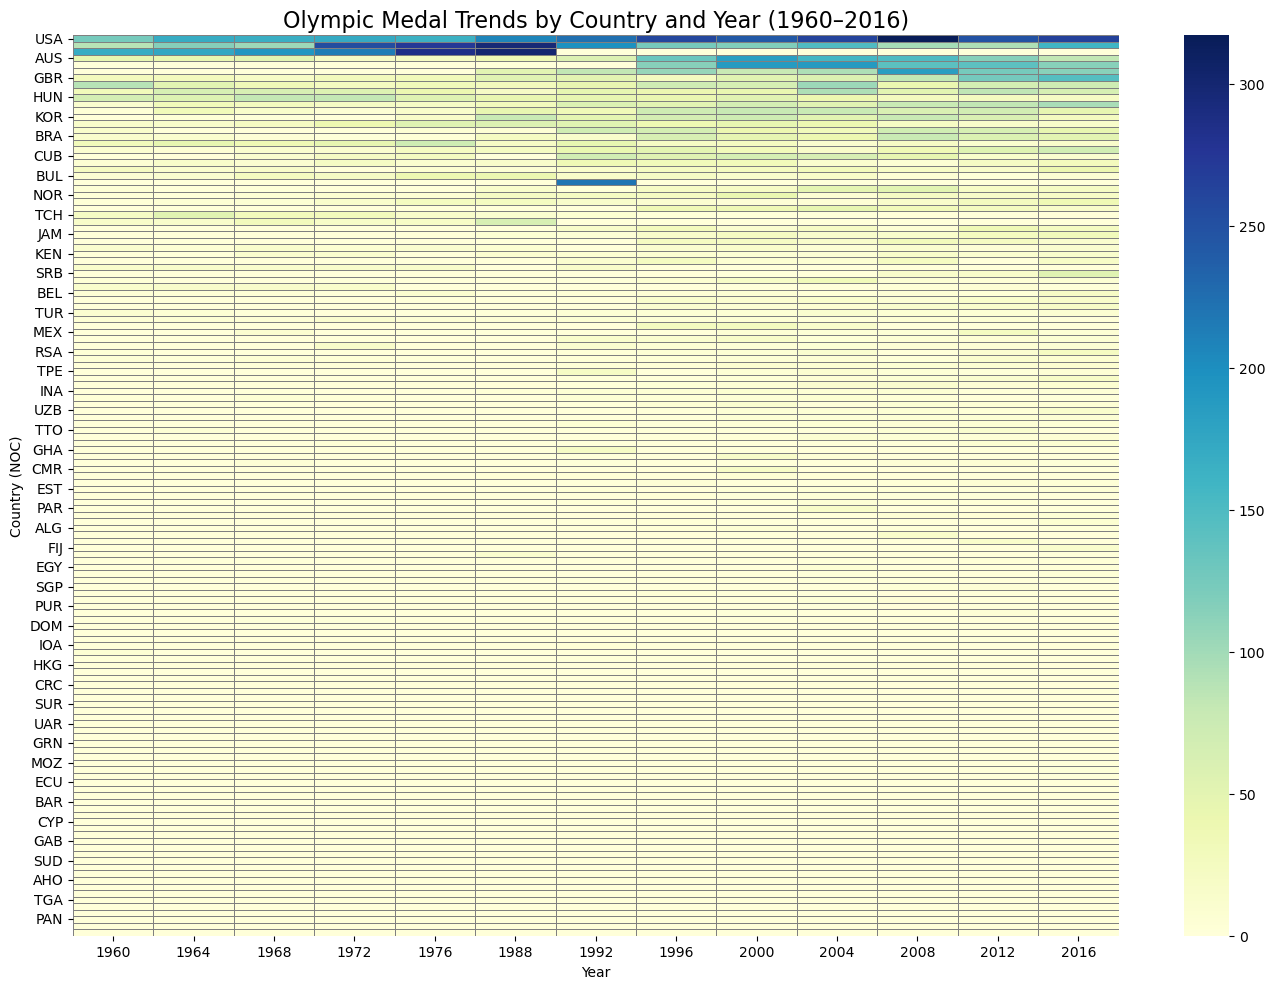

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns

# 透视表，每个国家每年奖牌总数
medal_matrix = pivot.copy()

# 排序国家（总奖牌数多的在前）
medal_matrix['total_sum'] = medal_matrix.sum(axis=1)
medal_matrix = medal_matrix.sort_values('total_sum', ascending=False).drop(columns='total_sum')

plt.figure(figsize=(14,10))
sns.heatmap(medal_matrix, cmap="YlGnBu", linewidths=0.5, linecolor='gray')
plt.title("Olympic Medal Trends by Country and Year (1960–2016)", fontsize=16)
plt.xlabel("Year")
plt.ylabel("Country (NOC)")
plt.tight_layout()
plt.show()


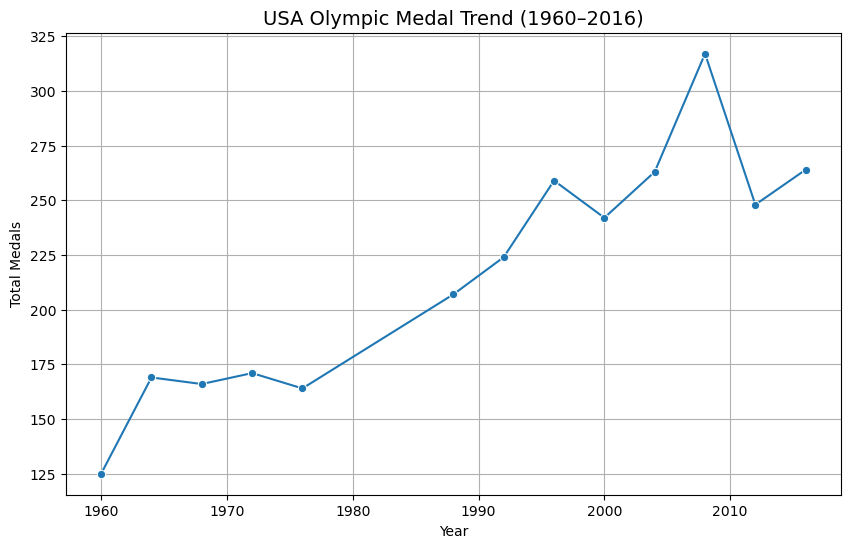

In [36]:
country = 'USA' 
country_medals = pivot.loc[country]

plt.figure(figsize=(10,6))
sns.lineplot(x=country_medals.index, y=country_medals.values, marker='o')
plt.title(f"{country} Olympic Medal Trend (1960–2016)", fontsize=14)
plt.xlabel("Year")
plt.ylabel("Total Medals")
plt.grid(True)
plt.show()


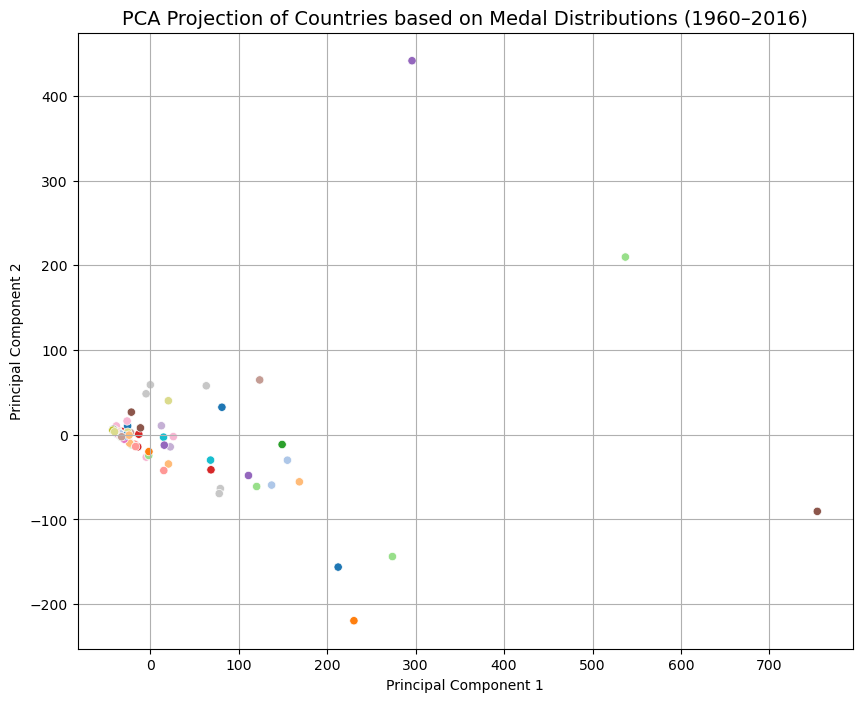

In [37]:
from sklearn.decomposition import PCA

# 使用1960–2016的所有奖牌数据进行降维
X_pca = pivot.copy()

# 可能某些国家所有年都为0，剔除
X_pca = X_pca[X_pca.sum(axis=1) > 0]

pca = PCA(n_components=2)
X_reduced = pca.fit_transform(X_pca)

# 构建降维结果 DataFrame
df_pca = pd.DataFrame({
    'PCA1': X_reduced[:, 0],
    'PCA2': X_reduced[:, 1],
    'noc': X_pca.index
})

plt.figure(figsize=(10,8))
sns.scatterplot(data=df_pca, x='PCA1', y='PCA2', hue='noc', legend=False, palette='tab20')
plt.title("PCA Projection of Countries based on Medal Distributions (1960–2016)", fontsize=14)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid(True)
plt.show()
